In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

# own imports
import sys
sys.path.append("../")

# setup GPU
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


# Implementations

### Implement computation of filterbank matrices

In [2]:
def compute_filterbank(A, B, log_var, gt_X, gt_Y, log_dt, N):
    """ Compute the two filterbank matrices

    Input
        log_var :   The log of the variance.
        gt_X    :   Used to calculate center X coordinate.
        gt_Y    :   Used to calculate center Y coordinate.
        log_dt  :   Used to calculate the stride.
        N       :   Number of points in the patch in each dimension.

    Return
        F_X     :   Horizontal filterbank matrix of size (N, A)
        F_Y     :   Vertical filterbank matrix of size (N, B)
    """ 

    # retrieve non-log versions
    var = torch.exp(log_var + 1e-8)

    # calculate grid center
    g_X = (A + 1) * (gt_X + 1) / 2
    g_Y = (B + 1) * (gt_Y + 1) / 2

    # calculate stride
    d = torch.exp(log_dt) * (torch.max(torch.tensor([A, B])) - 1) / (N - 1)
    
    # compute filters
    F_X = torch.zeros((N, A)).to(device)
    F_Y = torch.zeros((N, B)).to(device)

    # construct mean vectors
    mu_X = torch.linspace(
        g_X + (- N/2 - 0.5) * d, 
        g_X + (N-1 - N/2 - 0.5) * d,
        N
    ).to(device)
    mu_Y = torch.linspace(
        g_Y + (- N/2 - 0.5) * d, 
        g_Y + (N-1 - N/2 - 0.5) * d,
        N
    ).to(device)

    # Compute filter matrices
    for a in range(A):
        F_X[:, a] = torch.exp( -(a - mu_X)**2 / (2 * var))

    for b in range(B):
        F_Y[:, b] = torch.exp( -(b - mu_Y)**2 / (2 * var))

    # normalize filters (should each sum to 1)
    F_X = F_X / torch.sum(F_X)
    F_Y = F_Y / torch.sum(F_Y)

    return F_X, F_Y

### Function to apply filters to the cropped image

In [3]:
def filter_img(img, F_X, F_Y, log_gamma):
    return torch.exp(log_gamma) * torch.matmul(torch.matmul(F_Y, img), F_X.T)

# Load image data (MNIST)

In [4]:
# define lambda func
def tmp_lambda(x):
    return torch.bernoulli(x)

# load / download the data
BATCH_SIZE = 64
mnist_data = MNIST(
    './', 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(tmp_lambda)
    ])
)

kwargs = {'num_workers': 2, 'pin_memory': True} if cuda else {}
data_loader = DataLoader(
    mnist_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


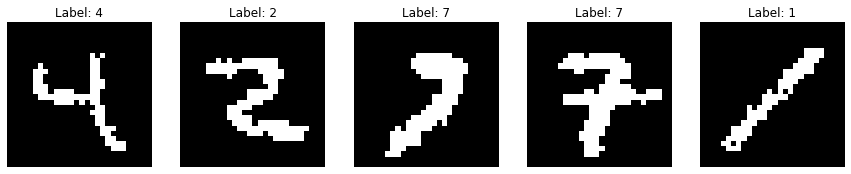

In [5]:
# Plot a few samples
data_iter = iter(data_loader)
images, labels = data_iter.next()

N = 5
f, ax = plt.subplots(1, N, figsize=(3*N, 6))
for i in range(N):
    ax[i].imshow(images[i, 0], cmap='gray')
    ax[i].set_title(f'Label: {labels[i]}')
    ax[i].axis('off')
plt.show()

# Inspect effects of Filterbank matrices

### Plot functions

In [8]:
def plot_filterbanks(F_X, F_Y):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(F_X, cmap='gray')
    ax[0].set_title('Filter X')
    ax[0].set_xlabel('i')
    ax[0].set_ylabel('a')
    ax[1].imshow(F_Y, cmap='gray')
    ax[1].set_title('Filter Y')
    ax[1].set_xlabel('j')
    ax[1].set_ylabel('b')
    plt.show()

def plot_filteredimg(ax, img, F_X, F_Y, log_gamma, title="Filtered image"):
    img_filt = filter_img(img, F_X, F_Y, log_gamma)
    # print(img_filt.shape)
    ax.imshow(img_filt, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

### Inspect

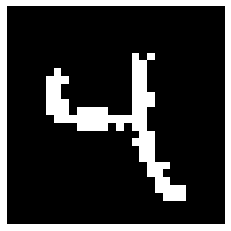

In [9]:
# Pick a single image
img = images[0][0].to(device)
plt.imshow(img.cpu(), cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# Define parameters
A = img.shape[0]
B = img.shape[1]
N = 100    # resolution of filters
gt_X = 0  # x-focus
gt_Y = 0  # y-focus

log_dt = torch.tensor([-0.001, -0.01, -0.1, 0, 0.1])
log_var = torch.tensor([2, 1, 0.75, 0.5, 0, -0.5, -0.75, -1, -2]) # , -2, -3
# log_g = [5, 1, -1, -5]
lg = torch.tensor([0]).to(device)

Ni = len(log_var)
Nj = len(log_dt) #len(log_g)

In [11]:
torch.max(torch.tensor(img.shape))

tensor(28)

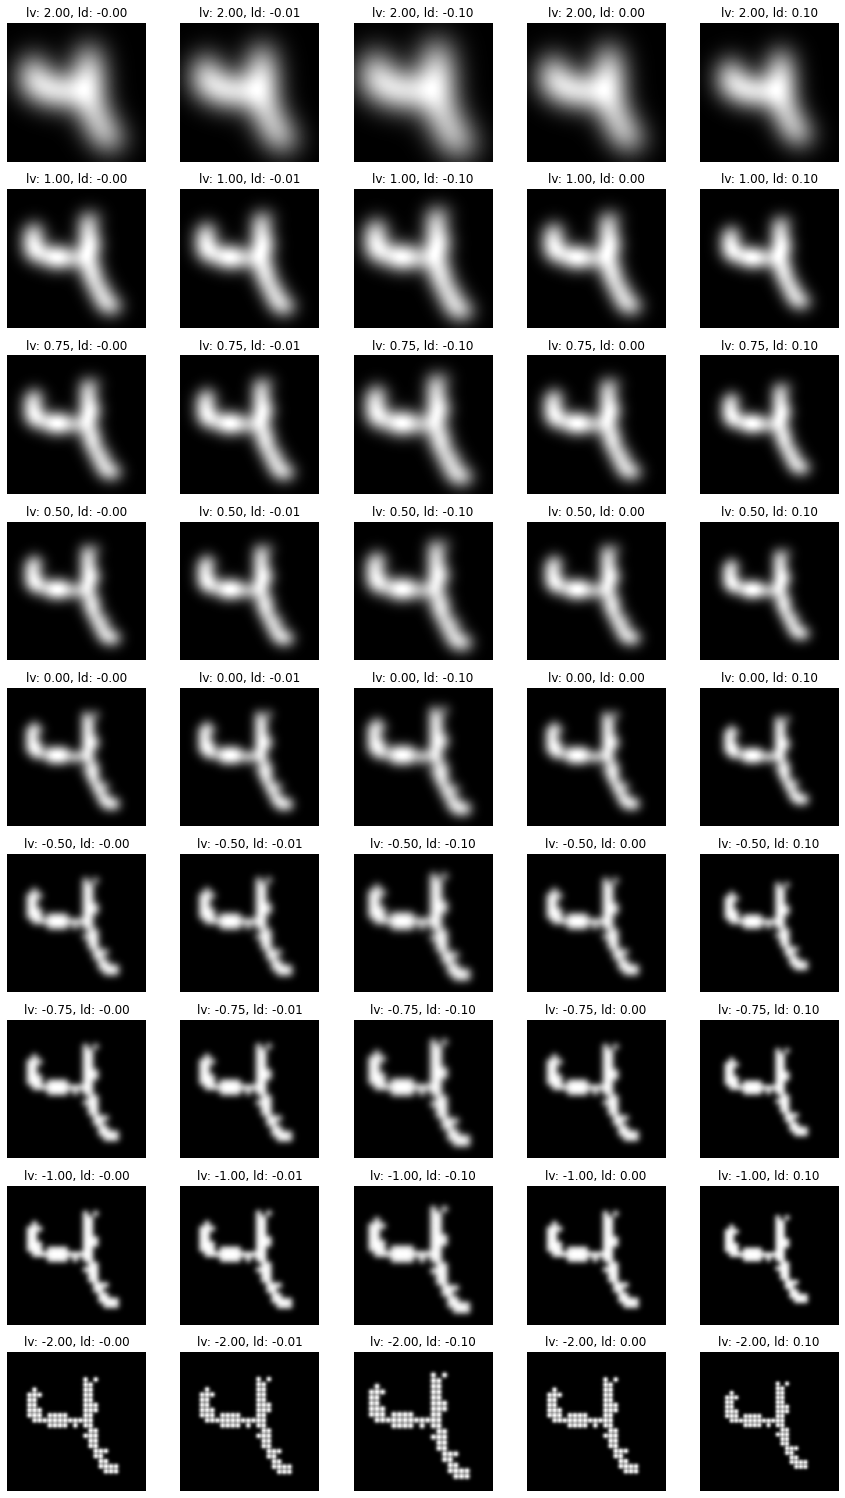

In [13]:
# Iterate over 
f, ax = plt.subplots(Ni, Nj, figsize=(Nj*3, Ni*3))
for i, lv in enumerate(log_var):
    for j, ld in enumerate(log_dt):
    # for j, lg in enumerate(log_g):
        title = "lv: {:.2f}, ld: {:.2f}".format(lv, ld)
        F_X, F_Y = compute_filterbank(A, B, lv, gt_X, gt_Y, ld, N)
        plot_filteredimg(ax[i,j], img.cpu(), F_X.cpu(), F_Y.cpu(), lg.cpu(), title)
plt.show()